Matplotlib is building the font cache; this may take a moment.
/Users/gemmali/jupyter/venv/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/var/folders/t3/z10k2_55249033xp3t7003jm0000gn/T/ipykernel_22780/1180529870.py:55: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for agent in random.sample(self.schedule.agents, int(0.1 * N)):


Step 0


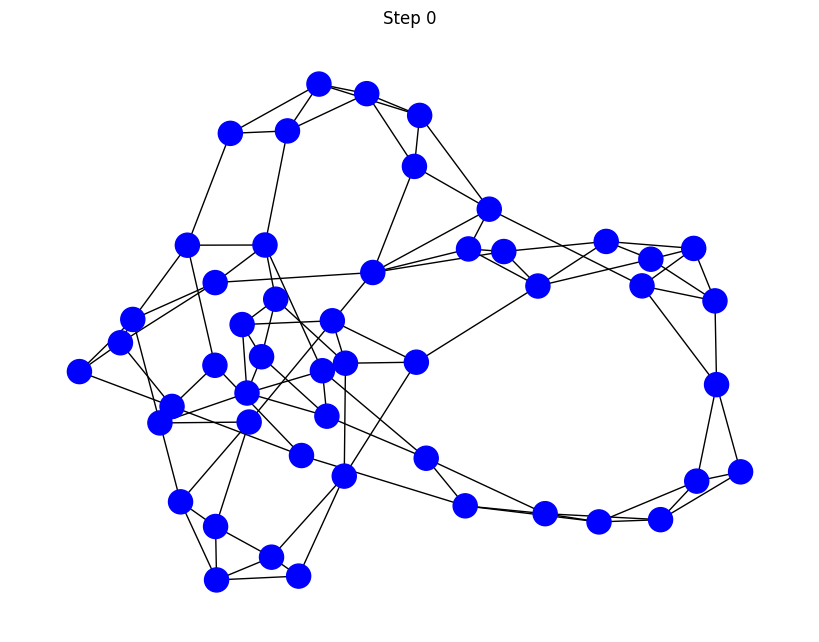

Step 1


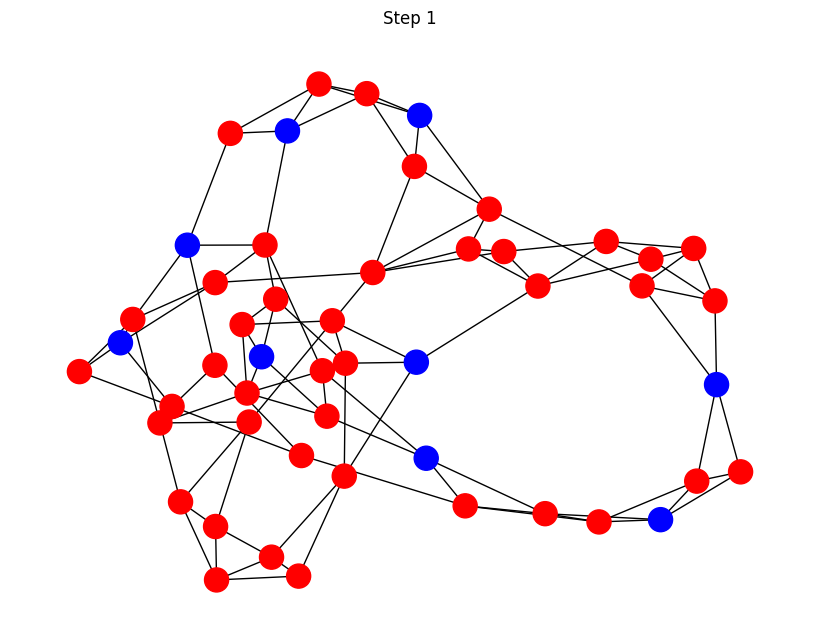

Step 2


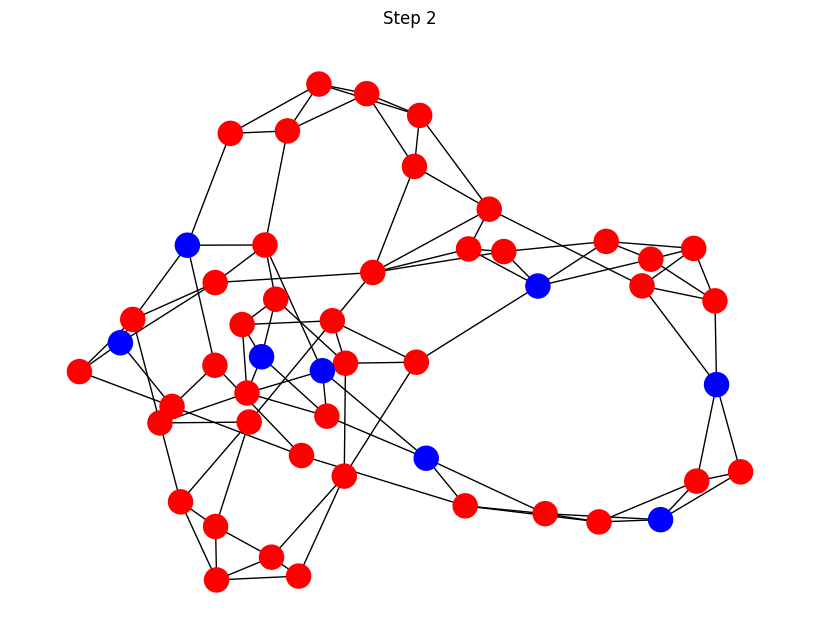

Step 3


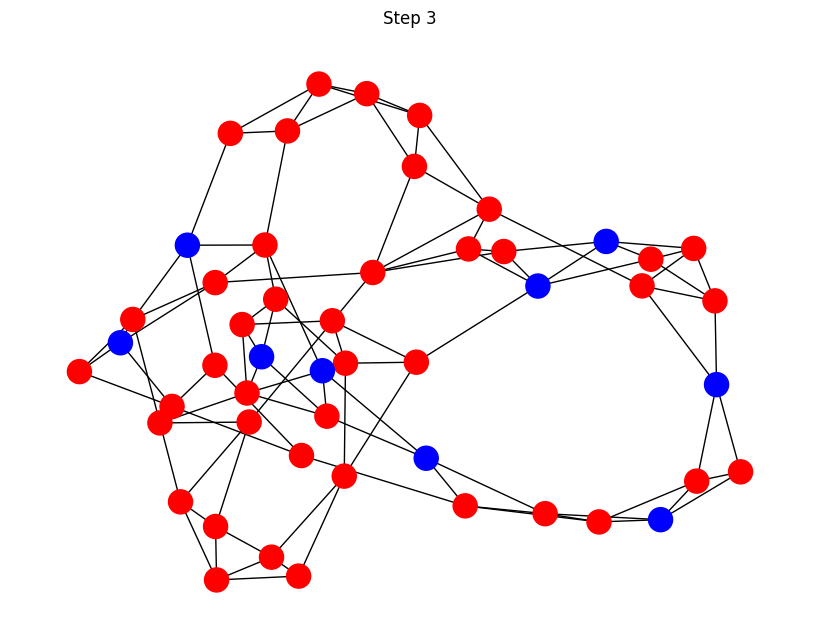

Step 4


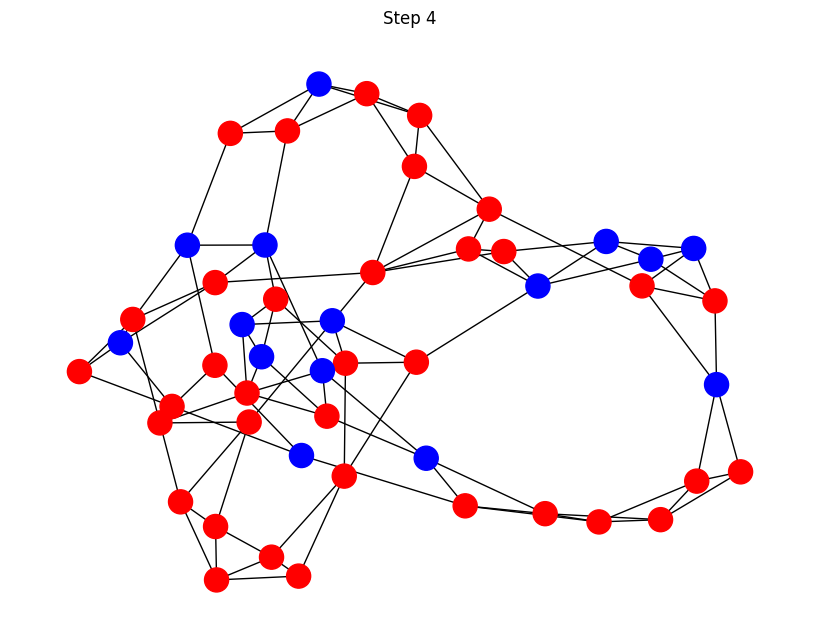

Step 5


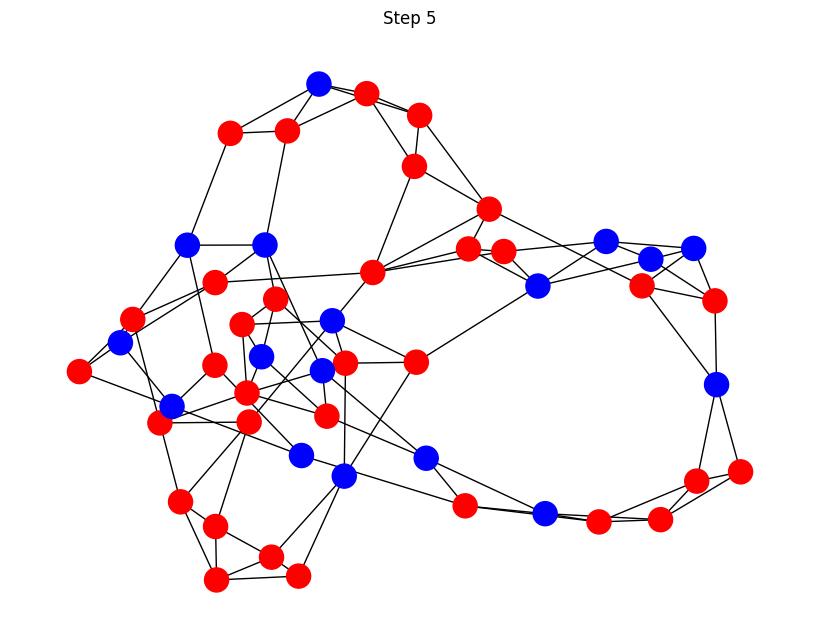

Step 6


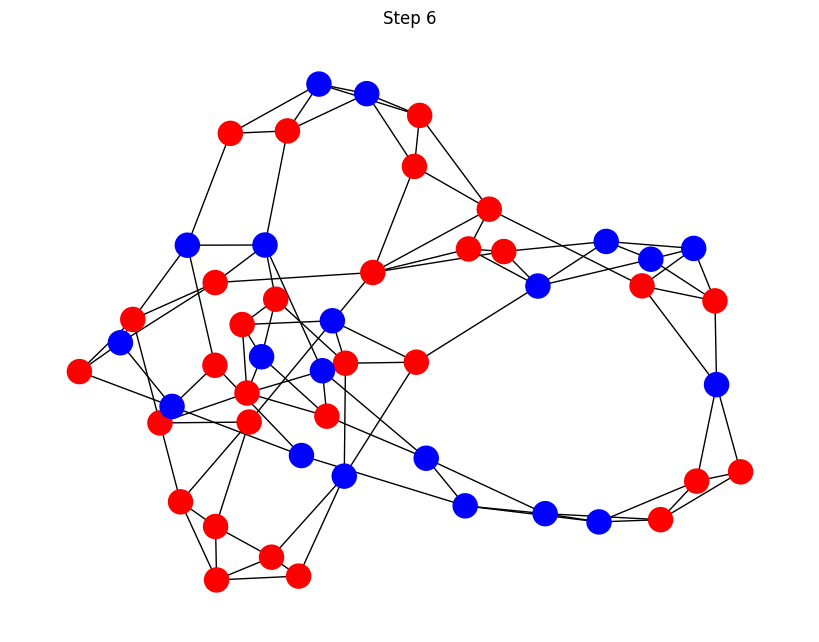

Step 7


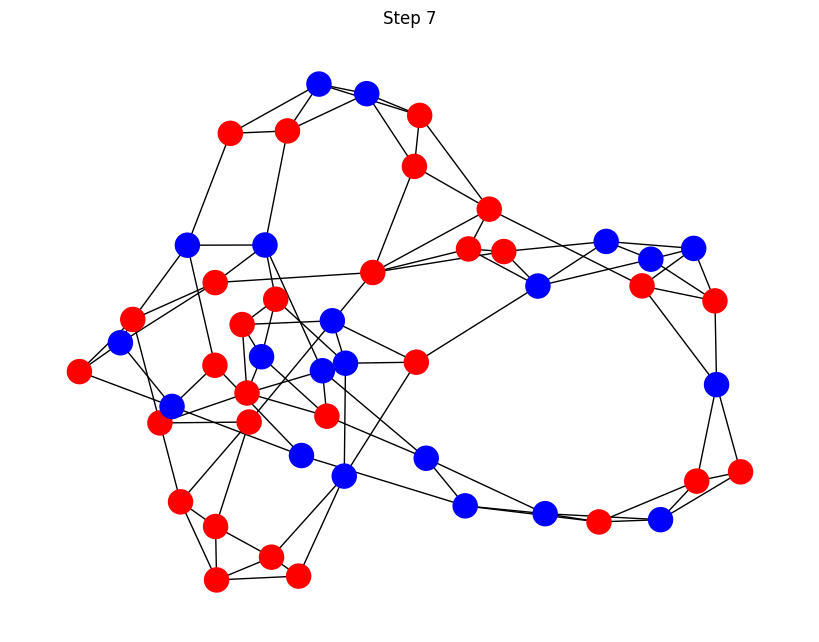

Step 8


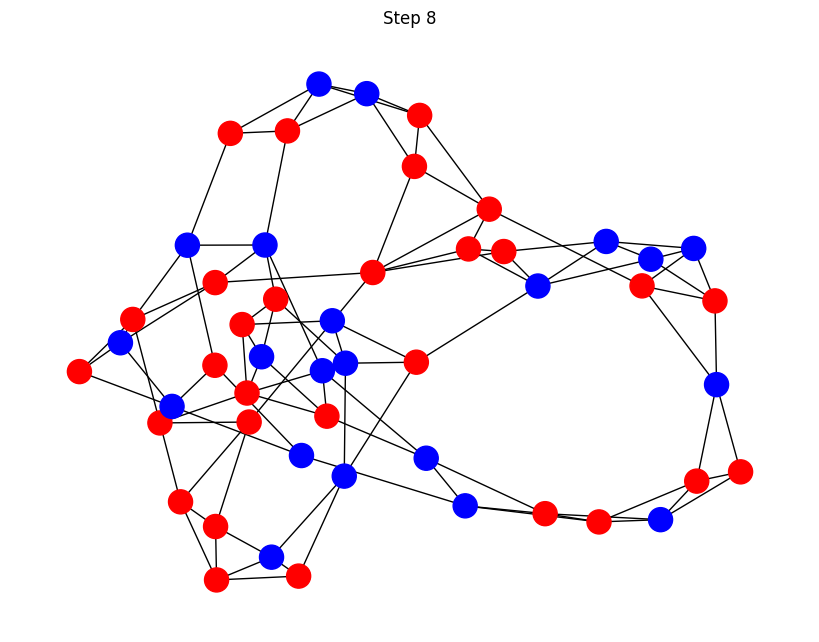

Step 9


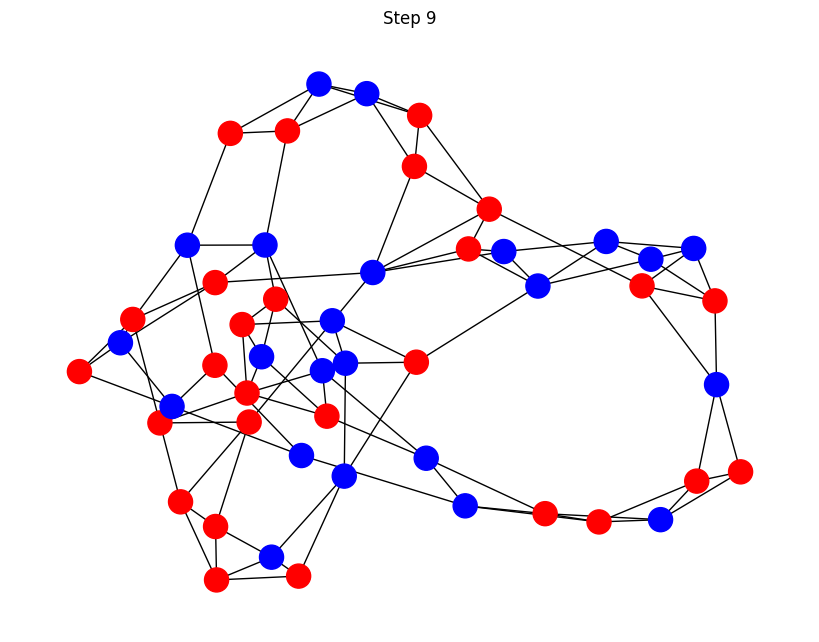

/Users/gemmali/jupyter/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gemmali/jupyter/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gemmali/jupyter/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gemmali/jupyter/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gemmali/jupyter/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 34394

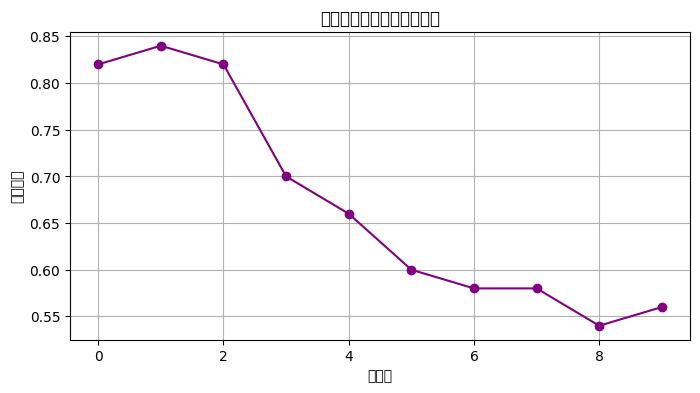

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.space import NetworkGrid
from mesa.time import SimultaneousActivation
import random
import numpy as np

# ----------------------
# 1. Agent 设定
# ----------------------
class DKAgent(Agent):
    def __init__(self, unique_id, model, knowledge, confidence):
        super().__init__(unique_id, model)
        self.knowledge = knowledge
        self.confidence = confidence
        self.belief_prob = knowledge  # 初始化主观信念概率
        self.belief = False           # 用于红蓝颜色显示

    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        for neighbor in neighbors:
            if isinstance(neighbor, DKAgent):
                self.bayesian_update(neighbor)
        self.belief = self.belief_prob > 0.5

    def bayesian_update(self, neighbor):
        trust = neighbor.knowledge
        likelihood = trust if neighbor.belief_prob > 0.5 else 1 - trust
        prior = self.belief_prob
        numerator = likelihood * prior
        denominator = numerator + (1 - likelihood) * (1 - prior)
        if denominator != 0:
            self.belief_prob = numerator / denominator

# ----------------------
# 2. 模型设定
# ----------------------
class DKModel(Model):
    def __init__(self, N=50, avg_degree=4, rewiring_prob=0.1):
        self.num_agents = N
        self.G = nx.watts_strogatz_graph(n=N, k=avg_degree, p=rewiring_prob)
        self.grid = NetworkGrid(self.G)
        self.schedule = SimultaneousActivation(self)
        self.belief_history = []

        for i, node in enumerate(self.G.nodes()):
            kl = random.uniform(0, 1)
            cl = np.clip(1 - kl + random.uniform(-0.1, 0.1), 0, 1)
            agent = DKAgent(i, self, kl, cl)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        # 初始10% agent 设为“强信假消息”
        for agent in random.sample(self.schedule.agents, int(0.1 * N)):
            agent.belief_prob = 0.9

    def step(self):
        self.schedule.step()
        proportion = sum(agent.belief for agent in self.schedule.agents) / self.num_agents
        self.belief_history.append(proportion)

# ----------------------
# 3. 可视化函数
# ----------------------
def draw_network(model, step):
    colors = ['red' if agent.belief else 'blue' for agent in model.schedule.agents]
    pos = nx.spring_layout(model.G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw(model.G, pos, node_color=colors, with_labels=False, node_size=300)
    plt.title(f"Step {step}")
    plt.show()

# ----------------------
# 4. 运行仿真 + 可视化
# ----------------------
model = DKModel()

for step in range(10):
    print(f"Step {step}")
    draw_network(model, step)
    model.step()

# ----------------------
# 5. 画传播曲线
# ----------------------
plt.figure(figsize=(8, 4))
plt.plot(model.belief_history, marker='o', color='purple')
plt.title("虚假信息信者比例变化趋势")
plt.xlabel("时间步")
plt.ylabel("信者比例")
plt.grid(True)
plt.show()